<a href="https://colab.research.google.com/github/LinhTo11/BA775-B2-Team-3-NYC-Payroll/blob/main/B2_Team3_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uncovering city's budget spending on municipal employees payment





Business problem: Our goal is to analyze and determine how the City's financial resources are distributed and how much of the budget is spent on overtime. For the workers, they will benefit from knowing the allocations and average payment of municipal jobs in New York city, while the public will be interested in knowing how the city's budget is being spent. We will use Linear Regression Model on uncovering the statistical relations between tenure and bases salary, and between tenure and overtime hours.

Data source: https://data.cityofnewyork.us/City-Government/Citywide-Payroll-Data-Fiscal-Year-/k397-673e


#  Approaches: Full data analysis cycle

**1.   Data preparation**
*   Data source piping to Big Query and Colab
*   Identify data anomalies
*   Interrogate column properties
*   Resolve inconsistencies, unexpected or null values, and data quality issues

**2.   Data modelling**
*   Remove unnecessary rows and columns
*   Define a relationship's cardinality and cross-filter direction
*   Create a common date table
*   Create calculated columns

**3. Data Analytics**
*   Apply slicers and filters
*   Perform top N analysis
*   Explore statistical summary
*   Identify outliers
*   Conduct Time Series analysis
*   Use groupings and binnings
*   Apply AI Insights

**4. Data visualization**
*   Add visualization items to sheets and dashboards
*   Choose an appropriate visualization type
*   Apply slicing and filtering
*   Apply sorting 
*   Configure data classification
*   Drilldown into data using interactive visuals
*   Mobile view
*   Publish


















# 1. Data Preparation





## Data Piping

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
%%bigquery --project=ba-775-b2-team-3
SELECT * FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll` LIMIT 5

,Fiscal_Year,Payroll_Number,Agency_Name,Last_Name,First_Name,Mid_Init,Agency_Start_Date,Work_Location_Borough,Title_Description,Leave_Status_as_of_June_30,Base_Salary,Pay_Basis,Regular_Hours,Regular_Gross_Paid,OT_Hours,Total_OT_Paid,Total_Other_Pay
0,2014,2,OFFICE OF THE MAYOR,CAPORALE,CAITLIN,None,2008-07-07,None,RESEARCH PROJECTS COORD,ACTIVE,74400.0,per Annum,1825.0,63161.81,0.0,0.0,0.0
1,2014,2,OFFICE OF THE MAYOR,CUMMINGS,KEVIN,S,2010-03-17,None,SPECIAL ASSISTANT,ACTIVE,85000.0,per Annum,1825.0,83769.76,0.0,0.0,0.0
2,2014,2,OFFICE OF THE MAYOR,MOORE,KARA,D,2010-07-26,None,SPECIAL ASSISTANT,CEASED,126500.0,per Annum,919.0,75941.94,0.0,0.0,500.0
3,2014,2,OFFICE OF THE MAYOR,SPAVINS,JOHN,C,2011-06-06,None,RESEARCH PROJECTS COORD,CEASED,110000.0,per Annum,919.0,111736.24,0.0,0.0,0.0
4,2014,2,OFFICE OF THE MAYOR,DUNCAN,CHARLA,A,2013-01-09,None,MAYORAL OFFICE ASSISTANT,CEASED,20.0,per Hour,0.0,1626.33,0.0,65.0,0.0


##Column Properties






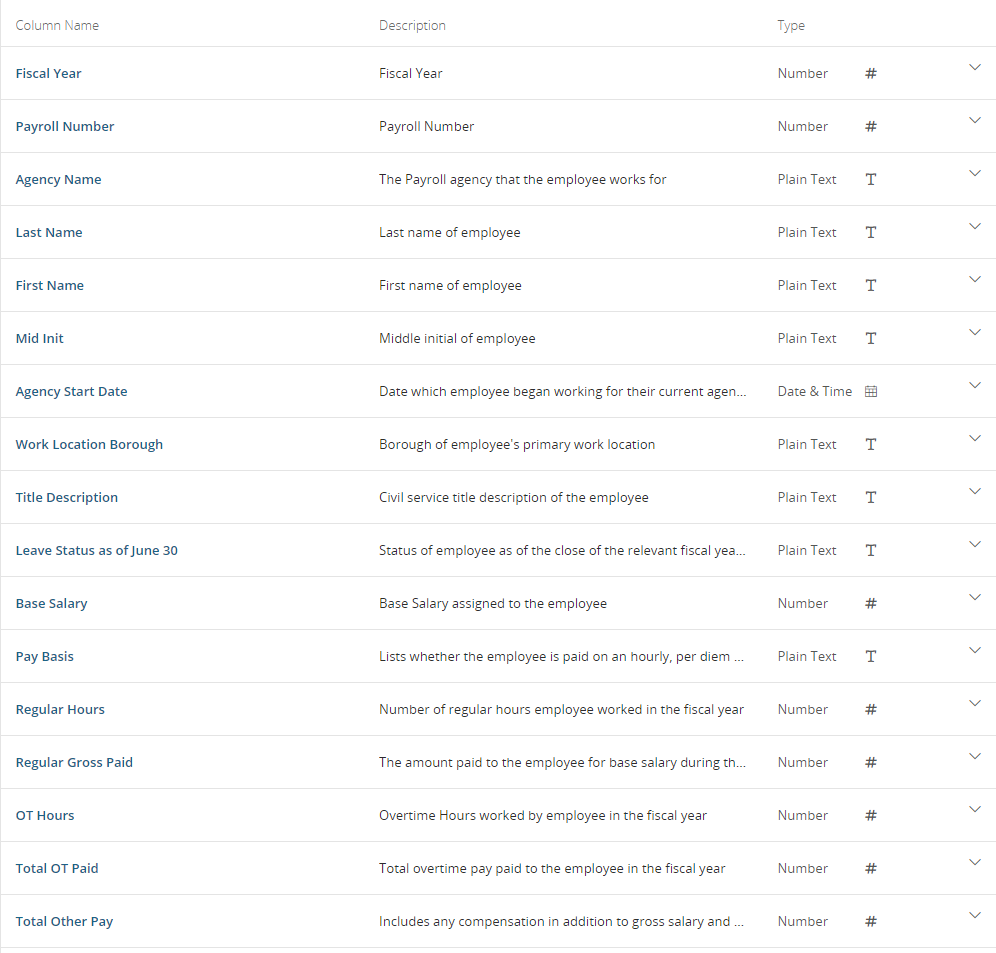

## Data anomolities: 

*   Title_Description has a lot of strange characters (see below code)
*   Agency_start_date = null
*   Work_location_borough = null
*   regular_hours < 0
*   Regular_Gross_Paid < 0
*   OT_Hours < 0
*   Total_OT_Paid < 0
*   Total_Other_Pay < 0



In [ ]:
%%bigquery --project=ba-775-b2-team-3
SELECT DISTINCT Work_location_borough FROM ba-775-b2-team-3.NYC_Payroll.NYC_Payroll

,Work_location_borough
0,None
1,Bronx
2,Richmond
3,Queens
4,Manhattan
5,BROOKLYN
6,MANHATTAN
7,QUEENS
8,BRONX
9,RICHMOND


In [ ]:
%%bigquery --project=ba-775-b2-team-3
SELECT DISTINCT Title_Description FROM ba-775-b2-team-3.NYC_Payroll.NYC_Payroll
WHERE REGEXP_CONTAINS(Title_Description, '[^0-9A-Za-z --\']')
ORDER BY Title_Description

,Title_Description
0,*DIRECTOR OF HEALTH CARE PROGRAM PLANNING/ANAL...
1,12 MONTH SPECIAL EDUCATION ASST. PRINCIPAL
2,?*COMMUNITY LIAISON WORKER
3,?*DENTIST
4,?*ELEVATOR OPERATOR
...,...
80,SUPERVISING FM-MGL DET: CHIEF OF STAFF TO FIRE...
81,SUPERVISING RACKETS INVESTIGATOR START >4-24-0...
82,WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92
83,WARDEN-DEPUTY WARDEN IN COMM TED < 11/1/92


# 2. Data Cleaning and Data modelling

* In the raw data we have a common date table called "Agency_Start_Date" that has the data type of date-time and YYYY-MM-DD. We will create a caculated column called "Tenure" to specify the number of years that a person has stayed in the company, with the Tenure = 2021 - YYYY

* We will also create another new caculated column called "Total_Salary", with Total_Salary = Regular_Gross_Paid + Total_OT_paid + Total_Other_Pay

(We would have liked to use the column (Pay_Bases and Regular_Hours to calculate with the presumption that Base_Salary * Regular_Hours = Regular_Gross_Paid but some of the data didn't match)

* Work_location_borough has a hierarchy and will be set like this:
> New York State
> - ULSTER
> - NASSAU
> - WESTCHESTER
> - NYC
>   - BROOKLYN
    - MANHATTAN
    - QUEENS
    - BRONX
    - RICHMOND
> - SULLIVAN
> - SCHOHARIE
> - DUTCHESS
> - ALBANY

## Cleaning code

In [ ]:
# This is the query that we put in BigQuery to create a New clean table 
# Don't run it or it will cost a lot of minutes of your life

# %%bigquery --project=ba-775-b2-team-3
CREATE OR REPLACE TABLE ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned
AS
SELECT 
  Fiscal_Year,
  Agency_Name,
  Agency_Start_Date,
  EXTRACT(year FROM Agency_Start_Date) AS Year,
  2021 - EXTRACT(year FROM Agency_Start_Date) AS Tenure,
  EXTRACT (month FROM Agency_Start_Date) AS Month_Numeric,
  FORMAT_DATETIME("%B", Agency_Start_Date) Month_Alphabet,
  Work_Location_Borough,
  Leave_Status_as_of_June_30,
  Base_Salary, 
  Pay_Basis,
  Regular_Hours, 
  Regular_Gross_Paid,
  OT_Hours,
  Total_OT_Paid,
  Total_Other_Pay,
  Regular_Gross_Paid + Total_OT_paid + Total_Other_Pay AS Total_Salary,
  regexp_replace(Title_Description, '[?*]', '') AS Title_Description


FROM ba-775-b2-team-3.NYC_Payroll.NYC_Payroll
-- WHERE REGEXP_CONTAINS(Title_Description, '[^0-9A-Za-z --\']')


WHERE Title_Description IS NOT NULL 
AND Fiscal_Year IS NOT NULL 
AND Agency_Start_Date IS NOT NULL
AND Work_Location_Borough IS NOT NULL
AND Leave_Status_as_of_June_30 IS NOT NULL
AND Base_Salary IS NOT NULL 
AND Base_Salary > 0
AND Pay_Basis IS NOT NULL
AND Regular_Hours IS NOT NULL 
AND Regular_Hours > 0
AND Regular_Gross_Paid IS NOT NULL
AND Regular_Gross_Paid > 0
AND OT_Hours IS NOT NULL
And OT_Hours > 0
AND Total_OT_Paid IS NOT NULL
AND Total_OT_Paid > 0
AND Total_Other_Pay IS NOT NULL
AND Total_Other_Pay > 0

## The clean table

Finally, we have a clean table called "NYC_Payroll_Cleaned" and we will use this clean table for further data analytics

In [ ]:
%%bigquery --project=ba-775-b2-team-3
SELECT * FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned` LIMIT 5

,Fiscal_Year,Agency_Name,Agency_Start_Date,Year,Tenure,Month_Numeric,Month_Alphabet,Work_Location_Borough,Leave_Status_as_of_June_30,Base_Salary,Pay_Basis,Regular_Hours,Regular_Gross_Paid,OT_Hours,Total_OT_Paid,Total_Other_Pay,Total_Salary,Title_Description
0,2017,POLICE DEPARTMENT,1980-07-07,1980,41,7,July,RICHMOND,ACTIVE,41391.00,per Annum,1795.00,42538.65,2.0,50.32,9006.22,51595.19,POLICE ADMINISTRATIVE AIDE
1,2015,DEPT OF ENVIRONMENT PROTECTION,1981-12-01,1981,40,12,December,QUEENS,ACTIVE,85019.00,per Annum,2084.57,88853.74,28.5,1978.33,8525.25,99357.32,SUPERVISOR
2,2015,NYC HOUSING AUTHORITY,1983-04-27,1983,38,4,April,MANHATTAN,CEASED,324.72,per Day,1068.57,71157.33,120.0,9132.75,804.23,81094.31,PLASTERER
3,2017,POLICE DEPARTMENT,1983-04-27,1983,38,4,April,QUEENS,ACTIVE,50696.00,per Annum,1795.00,49593.33,232.0,8121.05,4991.30,62705.68,SENIOR POLICE ADMINISTRATIVE AIDE
4,2019,POLICE DEPARTMENT,1983-04-27,1983,38,4,April,QUEENS,ACTIVE,52908.00,per Annum,1785.00,53223.48,113.0,4281.41,5332.40,62837.29,SENIOR POLICE ADMINISTRATIVE AIDE


# 3. Data Analytics

Asking the real question: who would benefit from seeing this data?

## IAMA Job seeker

The "Job seeker" will be one of the types of people to benefit from analyzing this dataset. The "Job seeker" will be interested in topics such as: how are jobs allocated between different locations, what is the average salary between different locations and job titles. 

We will first take a look at the dataset, then analyze the average salary of workers through three key facts: work location, job description and tenure.



### Dive in the dataset

Firstly, we will take a look at the trends of maximum, minimum and average total salary over the period from 2014 to 2020.

- Conclusion：From the graph, the trends of minimum salary and average salary maintian at the same level. It can be explained as the economic environment and other factors didn't have an impact on the minimum and average salary of municipal employees in New York States. However, the maximum salary that New York States can pay for workers fluctuates with a sudden decrease and we will zoom in and see why it happened.



In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project = 'ba-775-b2-team-3')

In [ ]:
sql = """
SELECT 
  Fiscal_Year, 
  CAST(MAX(Total_Salary) AS INT) AS Max_Total_Salary, 
  CAST(MIN(Total_Salary) AS INT) AS Min_Total_Salary , 
  CAST(AVG(Total_Salary) AS INT) AS Avg_Total_Salary 
FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned` 
GROUP BY Fiscal_Year 
ORDER BY Fiscal_Year ASC
"""
df_1 = client.query(sql).to_dataframe()
df_1

,Fiscal_Year,Max_Total_Salary,Min_Total_Salary,Avg_Total_Salary
0,2014,118709,3954,51966
1,2015,274352,263,80283
2,2016,400663,315,85428
3,2017,373904,317,86814
4,2018,539098,187,84056
5,2019,310216,143,83960
6,2020,348888,232,86183


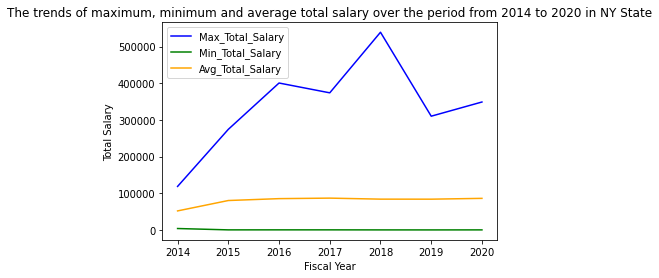

In [ ]:
import matplotlib.pyplot as plt
plt.plot( df_1.Fiscal_Year,df_1.Max_Total_Salary, 'b', label='Max_Total_Salary')
plt.plot( df_1.Fiscal_Year,df_1.Min_Total_Salary, 'g', label='Min_Total_Salary')
plt.plot( df_1.Fiscal_Year,df_1.Avg_Total_Salary, 'orange', label='Avg_Total_Salary')

plt.xlabel("Fiscal Year")
plt.ylabel("Total Salary")
plt.title('The trends of maximum, minimum and average total salary over the period from 2014 to 2020 in NY State')
plt.legend()
plt.show()

##***May Look into the sudden decrease of Max_total_salary happened during 2018-2019 at which location, what job title?***

### Analyze the percentage of job opportunities at different locations, for different title descriptions

using plt.pie()



### Analyzing the allocation of average salary

We analyze the relationships between average salary over three key factors:

- a. Work Location
- b. Title Description
- c. Tenure

a. Work Location
- Top 5 Avg_Total_Salary at different work location over the fiscal year from 2014 to 2020
- Count the number of apperances of each work location from the Top 5 List
- Top 10 the Avg_length of work overtime hours at different work location over recent 3 years

`Conclusion:`
- Over the fiscal year from 2014 to 2020, Average Total Salary in RICHMOND(7), DUTCHESS(6), QUEENS(6) is higher than that in other places of NY State. Especially, RICHMOND(7) is on the TOP 5 list of Average Total Salary for a 7th consecutive year.

- In recent 3 years, RICHMOND and QUEENS are ranked in the top 2 of the Avg_length of work overtime hours. However, DUTCHESS even is not shown in the top 10 list. So, DUTCHESS may be a good place for a job seeker, because it could provide a considerable salary without too many hour time hours.


In [ ]:
sql = """
SELECT * FROM 
  (SELECT *, 
    ROW_NUMBER() OVER (PARTITION BY Fiscal_Year ORDER BY Avg_Total_Salary DESC) as rn
  FROM(
    SELECT 
      Fiscal_Year,
      CAST(AVG(Total_Salary) AS INT64 ) AS Avg_Total_Salary,
      UPPER(Work_Location_Borough) AS Work_Location,
    FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
    WHERE  UPPER(Work_Location_Borough) IS NOT NULL
    GROUP BY 	Work_Location, Fiscal_Year
    ORDER BY Fiscal_Year ASC, Avg_Total_Salary DESC
    )
  )
WHERE rn >=1 and rn <=5
ORDER BY Fiscal_Year DESC

"""
df_3_a_1 = client.query(sql).to_dataframe()
df_3_a_1

In [41]:
%%bigquery --project=ba-775-b2-team-3

WITH Work_Location_Table
AS(SELECT * FROM 

  (SELECT 
    *, 
    ROW_NUMBER() OVER (PARTITION BY Fiscal_Year ORDER BY Avg_Total_Salary DESC) as rn
  FROM(
    SELECT 
      Fiscal_Year,
      CAST(AVG(Total_Salary) AS INT64 ) AS Avg_Total_Salary,
      Work_Location_Borough,
    FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
    WHERE 	Work_Location_Borough IS NOT NULL
    GROUP BY 	Work_Location_Borough, Fiscal_Year
    ORDER BY Fiscal_Year ASC, Avg_Total_Salary DESC))

  WHERE rn >=1 and rn <=5
  ORDER BY Fiscal_Year DESC)

SELECT UPPER(Work_Location_Borough) AS Work_Location, COUNT(UPPER(Work_Location_Borough)) AS Appearances_in_top_5
FROM Work_Location_Table
GROUP BY Work_Location
ORDER BY Appearances_in_top_5 DESC

,Work_Location,Appearances_in_top_5
0,RICHMOND,7
1,DUTCHESS,6
2,QUEENS,6
3,GREENE,5
4,ALBANY,3
5,ORANGE,2
6,MANHATTAN,2
7,SCHOHARIE,1
8,OTHER,1
9,BRONX,1


In [ ]:
%%bigquery --project=ba-775-b2-team-3

SELECT * EXCEPT(rn) FROM
  (SELECT * FROM 

    (SELECT *, 
    ROW_NUMBER() OVER (PARTITION BY Fiscal_Year ORDER BY Avg_OT_Hours	DESC) as rn
    FROM(
        SELECT 
        Fiscal_Year,
        CAST(AVG(OT_Hours) AS INT64 ) AS Avg_OT_Hours	,
        UPPER(Work_Location_Borough) AS Work_Location,
        FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
        WHERE UPPER(Work_Location_Borough) IS NOT NULL
        GROUP BY 	Work_Location, Fiscal_Year
        ORDER BY Fiscal_Year ASC, Avg_OT_Hours	DESC
        )
    )

  WHERE rn >=1 and rn <=5 and Fiscal_Year = 2020
  ORDER BY Fiscal_Year DESC
  ) a

LEFT JOIN
  (SELECT * FROM 

    (SELECT *, 
    ROW_NUMBER() OVER (PARTITION BY Fiscal_Year ORDER BY Avg_OT_Hours	DESC) as rn
    FROM(
        SELECT 
        Fiscal_Year,
        CAST(AVG(OT_Hours) AS INT64 ) AS Avg_OT_Hours	,
        UPPER(Work_Location_Borough) AS Work_Location,
        FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
        WHERE UPPER(Work_Location_Borough) IS NOT NULL
        GROUP BY 	Work_Location, Fiscal_Year
        ORDER BY Fiscal_Year ASC, Avg_OT_Hours	DESC
        )
    )

  WHERE rn >=1 and rn <=5 and Fiscal_Year = 2019
  ORDER BY Fiscal_Year DESC
  ) b

ON a. rn = b.rn

LEFT JOIN

  (SELECT * FROM 

    (SELECT *, 
    ROW_NUMBER() OVER (PARTITION BY Fiscal_Year ORDER BY Avg_OT_Hours	DESC) as rn
    FROM(
        SELECT 
        Fiscal_Year,
        CAST(AVG(OT_Hours) AS INT64 ) AS Avg_OT_Hours	,
        UPPER(Work_Location_Borough) AS Work_Location,
        FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
        WHERE UPPER(Work_Location_Borough) IS NOT NULL
        GROUP BY 	Work_Location, Fiscal_Year
        ORDER BY Fiscal_Year ASC, Avg_OT_Hours	DESC
        )
    )

  WHERE rn >=1 and rn <=5 and Fiscal_Year = 2020
  ORDER BY Fiscal_Year DESC
  ) c
ON b. rn = c.rn

,Fiscal_Year,Avg_OT_Hours,Work_Location,Fiscal_Year_1,Avg_OT_Hours_1,Work_Location_1,Fiscal_Year_2,Avg_OT_Hours_2,Work_Location_2
0,2020,306,RICHMOND,2019,255,RICHMOND,2020,306,RICHMOND
1,2020,293,BROOKLYN,2019,238,QUEENS,2020,293,BROOKLYN
2,2020,289,BRONX,2019,234,BRONX,2020,289,BRONX
3,2020,285,QUEENS,2019,226,BROOKLYN,2020,285,QUEENS
4,2020,279,MANHATTAN,2019,219,MANHATTAN,2020,279,MANHATTAN


b. Title Description

- Top 5 Avg_Total_Salary for different Title Description  over the fiscal year from 2014 to 2020

- Count the number of apperances of each Title Description from the Top 5 List

- Top 5 the length of work overtime hours for different Title Description over fiscal the year from 2014 to 2020



`Conclusion:`
- Over the fiscal year from 2014 to 2020, Average Total Salary in RICHMOND(7), DUTCHESS(6), QUEENS(6) is higher than that in other places of NY State. Especially, RICHMOND(7) is on the TOP 5 list of Average Total Salary for a 7th consecutive year.

- In recent 3 years, RICHMOND and QUEENS are ranked in the top 2 of the Avg_length of work overtime hours. However, DUTCHESS even is not shown in the top 10 list. So, DUTCHESS may be a good place for a job seeker, because it could provide a considerable salary without too many hour time hours.

In [ ]:
sql = """
SELECT * FROM 

  (SELECT 
    *, 
    ROW_NUMBER() OVER (PARTITION BY Fiscal_Year ORDER BY Avg_Total_Salary DESC) as rn
  FROM(
    SELECT 
      Fiscal_Year,
      CAST(AVG(Total_Salary) AS INT64 ) AS Avg_Total_Salary,
      Title_Description,
    FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
    WHERE Title_Description IS NOT NULL
    GROUP BY Title_Description, Fiscal_Year
    ORDER BY Fiscal_Year ASC, Avg_Total_Salary DESC
    )
  )

WHERE rn >=1 and rn <=5
ORDER BY Fiscal_Year DESC

"""
df_3_b_1 = client.query(sql).to_dataframe()
df_3_b_1

,Fiscal_Year,Avg_Total_Salary,Title_Description,rn
0,2020,282477,SENIOR SYSTEMS ANALYSTS,1
1,2020,241589,CAPTAIN DETAILED AS ASSISTANT CHIEF INSPECTOR,2
2,2020,237600,CITY MEDICAL EXAMINER,3
3,2020,224283,CAPTAIN D/A DEPUTY CHIEF INSPECTOR,4
4,2020,222328,CRANE OPERATOR AMPES,5
5,2019,222760,CITY MEDICAL EXAMINER,1
6,2019,207043,SENIOR STATIONARY ENGINEER,2
7,2019,197253,SUPERVISOR DOCKBUILDER,3
8,2019,192724,ASPHALT PLANT MANAGER,4
9,2019,192187,CRANE OPERATOR AMPES,5


In [ ]:
%%bigquery --project=ba-775-b2-team-3
WITH Title_Description_Table
AS(SELECT * FROM 

    (SELECT 
      *, 
      ROW_NUMBER() OVER (PARTITION BY Fiscal_Year ORDER BY Avg_Total_Salary DESC) as rn
    FROM
      (
      SELECT 
        Fiscal_Year,
        CAST(AVG(Total_Salary) AS INT64 ) AS Avg_Total_Salary,
        Title_Description,
      FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
      WHERE Title_Description IS NOT NULL
      GROUP BY Title_Description, Fiscal_Year
      ORDER BY Fiscal_Year ASC, Avg_Total_Salary DESC
      )
    )

  WHERE rn >=1 and rn <=5
  ORDER BY Fiscal_Year DESC)

SELECT Title_Description, COUNT(Title_Description) AS NUM
FROM Title_Description_Table
GROUP BY Title_Description
ORDER BY NUM DESC

In [ ]:
%%bigquery --project=ba-775-b2-team-3

SELECT * EXCEPT(rn) FROM
  (SELECT * FROM 

    (SELECT 
      *, 
      ROW_NUMBER() OVER (PARTITION BY Fiscal_Year ORDER BY Avg_OT_Hours DESC) as rn
    FROM
      (
      SELECT 
        Fiscal_Year,
        CAST(AVG(OT_Hours) AS INT64 ) AS Avg_OT_Hours,
        Title_Description,
      FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
      WHERE Title_Description IS NOT NULL
      GROUP BY Title_Description, Fiscal_Year
      ORDER BY Fiscal_Year ASC, Avg_OT_Hours DESC
      )
    )

  WHERE rn >=1 and rn <=10 and Fiscal_Year = 2020
  ORDER BY Fiscal_Year DESC
  ) a

LEFT JOIN
  (SELECT * FROM 

    (SELECT 
      *, 
      ROW_NUMBER() OVER (PARTITION BY Fiscal_Year ORDER BY Avg_OT_Hours DESC) as rn
    FROM
      (
      SELECT 
        Fiscal_Year,
        CAST(AVG(OT_Hours) AS INT64 ) AS Avg_OT_Hours,
        Title_Description,
      FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
      WHERE Title_Description IS NOT NULL
      GROUP BY Title_Description, Fiscal_Year
      ORDER BY Fiscal_Year ASC, Avg_OT_Hours DESC
      )
    )

  WHERE rn >=1 and rn <=10 and Fiscal_Year = 2019
  ORDER BY Fiscal_Year DESC
  ) b

ON a. rn = b.rn

LEFT JOIN

  (SELECT * FROM 

    (SELECT 
      *, 
      ROW_NUMBER() OVER (PARTITION BY Fiscal_Year ORDER BY  Avg_OT_Hours DESC) as rn
    FROM
      (
      SELECT 
        Fiscal_Year,
         CAST(AVG(OT_Hours) AS INT64 ) AS Avg_OT_Hours,
        Title_Description,
      FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
      WHERE Title_Description IS NOT NULL
      GROUP BY Title_Description, Fiscal_Year
      ORDER BY Fiscal_Year ASC,  Avg_OT_Hours DESC
      )
    )

  WHERE rn >=1 and rn <=10 and Fiscal_Year = 2018
  ORDER BY Fiscal_Year DESC
  ) c
ON b. rn = c.rn

c. Tenure

- Top 5 Avg_Total_Salary for different Tenure over the fiscal year from 2014 to 2020

- Count the number of apperances of each Tenure from the Top 5 List

- Top 5 the length of work overtime hours for different Tenure over the fiscal year from 2014 to 2020

---

In [ ]:
%%bigquery --project=ba-775-b2-team-3

SELECT 
  Fiscal_Year, 
  MAX(Total_Salary) AS Max_Total_Salary, 
  MIN(Total_Salary) AS Min_Total_Salary , 
  AVG(Total_Salary) AS Avg_Total_Salary 

FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned` 
GROUP BY Fiscal_Year 
ORDER BY Fiscal_Year ASC


,Fiscal_Year,Max_Total_Salary,Min_Total_Salary,Avg_Total_Salary
0,2014,118708.73,3953.79,51965.905649
1,2015,274351.97,262.50,80283.136073
2,2016,400663.07,314.75,85427.673871
3,2017,373904.10,316.75,86814.135115
4,2018,539098.32,186.63,84056.095263
5,2019,310215.65,143.33,83959.525485
6,2020,348887.99,231.58,86182.950740


In [ ]:
#Add this code to every line 
%%bigquery --project=ba-775-b2-team-3
SELECT blablablablabla FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`

In [ ]:
%%bigquery --project=ba-775-b2-team-3
SELECT 	
  Fiscal_Year, 
  COUNT(Fiscal_Year) 
FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned` 
group by Fiscal_Year 




,Fiscal_Year,f0_
0,2017,134267
1,2015,126461
2,2019,139660
3,2020,144529
4,2018,138291
5,2016,127740
6,2014,747


## IAMA NYC Citizen

The "NYC citizen" will be the second type to benefit from this dataset. The "NYC citizen" will be interested in topics such as: How did the government spend money on salary of how many people? And the difference in spending according to locations.

### Difference in salary throughout the years of 2015 - 2020








In [ ]:
%%bigquery --project=ba-775-b2-team-3
SELECT 
  Work_Location_Borough, 
  CAST(sum(total_salary) as int64) as budget_allocation
FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
WHERE fiscal_year = 2020
GROUP BY Work_Location_Borough
ORDER BY budget_allocation DESC

,Work_Location_Borough,budget_allocation
0,MANHATTAN,4278322055
1,QUEENS,3197360476
2,BROOKLYN,2853076825
3,BRONX,1543939975
4,RICHMOND,532132970
5,WESTCHESTER,24891051
6,ULSTER,9444835
7,SULLIVAN,4914679
8,DELAWARE,4250009
9,DUTCHESS,2242029


### Difference in salary allocation according to location 

In [ ]:
%%bigquery --project=ba-775-b2-team-3
SELECT 
  fiscal_year, 
  CAST(SUM(total_salary) as INT64) as budget_allocation
FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
GROUP BY fiscal_year
ORDER BY budget_allocation DESC

,fiscal_year,budget_allocation
0,2020,12455935688
1,2019,11725787329
2,2017,11656273479
3,2018,11624201470
4,2016,10912531060
5,2015,10152685671
6,2014,38818532


### The number of people who are still employed by different locations. 




In [ ]:
%%bigquery --project=ba-775-b2-team-3
SELECT 
  UPPER(Work_Location_Borough) AS Work_location,
  COUNT(*) AS Number_of_active_employees
FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
WHERE Leave_Status_as_of_June_30	= "ACTIVE"
GROUP BY Work_Location
ORDER BY Number_of_Active_employees DESC



,Work_location,Number_of_active_employees
0,MANHATTAN,247209
1,QUEENS,196668
2,BROOKLYN,180468
3,BRONX,99256
4,RICHMOND,30953
5,WESTCHESTER,1800
6,ULSTER,733
7,SULLIVAN,380
8,DELAWARE,323
9,PUTNAM,139


### Average base salary allocation throughout the years between 2015-2020 across various departments and the number of employees.



In [ ]:
%%bigquery --project=ba-775-b2-team-3
SELECT  
  Agency_Name,
  AVG(base_salary) AS Average_Salary,
  COUNT(*) AS Number_employees,
FROM `ba-775-b2-team-3.NYC_Payroll.NYC_Payroll_Cleaned`
WHERE fiscal_year <= 2020
AND fiscal_year >= 2015
GROUP BY Agency_Name
ORDER BY Average_Salary DESC


,Agency_Name,Average_Salary,Number_employees
0,PUBLIC ADMINISTRATOR-KINGS,110100.000000,2
1,TAX COMMISSION,89996.683113,106
2,OFFICE OF LABOR RELATIONS,80000.000000,1
3,DEPT. OF DESIGN & CONSTRUCTION,77563.989456,2884
4,OFFICE OF THE ACTUARY,72819.904255,94
...,...,...,...
74,COMMUNITY COLLEGE (BRONX),26693.652396,1077
75,DEPT OF PARKS & RECREATION,23379.787337,41979
76,COMMUNITY COLLEGE (MANHATTAN),19350.768255,2264
77,CULTURAL AFFAIRS,14020.517778,9


# 4. Data visualization